In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline # plot in cell
from sklearn import metrics
import pandas as pd
from scipy import signal
from scipy import stats


import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# for svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

feature_names = ['mean_x', 'mean_y', 'mean_z', 
                'rms_x', 'rms_y', 'rms_z',
                'std_x', 'std_y', 'std_z',
                'var_x', 'var_y', 'var_z',
                'med_x', 'med_y', 'med_z',
                'min_x', 'min_y', 'min_z',
                'max_x', 'max_y', 'max_z', 
                'pearsonr_xy', 'pearsonr_yz', 'pearsonr_zx']
              #  'mad_x', 'mad_y', 'mad_z']


target_names = ['Standing', 'Walking normal', 'Jumping', 
                'Jogging', 'Stairs up', 'Stairs down',
                'Fall front kness lying', 
                'Fall forward lying','Sideward lying']

#@param N : Filter order
#@param Wn : Cutoff frequency
def energyDistribution(action, number_samples, N, Wn):
    ans = 0
    ## Khúc này kiểu dữ liệu của action mà nàng muốn đưa vào là DataFrame
    for value in action:
        walk = dt[value]
        walk = walk.dropna()
        walk = walk.drop(0)
        walk.index = pd.RangeIndex(len(walk.index))

        # fAx after AVARAGE FILTER
        B, A = signal.butter(N, Wn, output='ba')
        smooth_data = signal.filtfilt(B,A, walk)
        x_filter = abs(walk[0:number_samples] - smooth_data[0:number_samples])
#        x_mean = abs (walk[0:number_samples] - np.mean(walk))
        ans += pow(x_filter,2)

    summ = 0
    for i in range (0, len(ans)):
        ans[i] = np.sqrt(ans[i])
        summ += ans[i]
    return summ

def featuresFromBuffer(at):
    feat = np.zeros(30)
    x = np.array(at.iloc[:,0], dtype=np.float64) 
    y = np.array(at.iloc[:,1], dtype=np.float64)
    z = np.array(at.iloc[:,2], dtype=np.float64)
    
    means = [np.mean(i) for i in [x, y, z]]
    feat[0:3] = means
    
    rms = [np.sqrt(np.mean(i**2)) for i in [x, y, z]]
    feat[3:6] = rms
    
    std = [np.std(i) for i in [x, y, z]]
    feat[6:9] = std
  
    var = [np.var(i) for i in [x, y, z]]
    feat[9:12] = var
    
    med = [np.median(i) for i in [x, y, z]]
    feat[12:15] = med
       
    Range1 = [ np.amin(i) for i in [x, y, z]]   
    feat[15:18] = Range1
    Range2 = [ np.amax(i) for i in [x, y, z]]    
    feat[18:21] = Range2
    
    x_pd = pd.Series(x)
    y_pd = pd.Series(y)
    z_pd = pd.Series(z)
    Pearsonr_xy = x_pd.corr(y_pd)
    feat[21] = Pearsonr_xy
    Pearsonr_yz = y_pd.corr(z_pd)
    feat[22] = Pearsonr_yz
    Pearsonr_zx = z_pd.corr(x_pd)
    feat[23] = Pearsonr_zx
    
    mad = [stats.median_absolute_deviation(i) for i in [x, y, z]]   
    feat[24:27] = mad
    
    number_samples = len(x)
    N = 3
    Wn = 0.1
    # giá trị chỗ hàm này là cần DataFrame này
    # thì nó sẽ là action (at)
    # Nhưng nếu như này thì cả x,y,z có còn coi là đặc trưng đc nữa ko?
    # Nàng thấy nhá. Tất cả mấy thằng trên đều cần 3 giá trị để lưu tương ứng x,y,z
    # Nhưng thằng dưới này thì chỉ ra đc 1 giá trị thôi cho cả x,y,z
    feat[28] = energyDistribution(at, number_samples, N, Wn)
#     feat[29] = energyDistribution(y, number_samples, N, Wn)
#     feat[30] = energyDistribution(z, number_samples, N, Wn)
    return feat

In [2]:
# Import data

dt = pd.read_excel (r'F:\Program\OneDrive\KHOÁ LUẬN 2020\Exactly_Data.xlsx')
dt.columns
dt.shape

Index(['STD', 'Unnamed: 1', 'Unnamed: 2', 'WAL', 'Unnamed: 4', 'Unnamed: 5',
       'JUM', 'Unnamed: 7', 'Unnamed: 8', 'JOG', 'Unnamed: 10', 'Unnamed: 11',
       'STU', 'Unnamed: 13', 'Unnamed: 14', 'STN', 'Unnamed: 16',
       'Unnamed: 17', 'FKL', 'Unnamed: 19', 'Unnamed: 20', 'FOL',
       'Unnamed: 22', 'Unnamed: 23', 'SDL', 'Unnamed: 25', 'Unnamed: 26'],
      dtype='object')

(28939, 27)

In [3]:
Standing = dt[['STD', 'Unnamed: 1', 'Unnamed: 2']] 
# Delete columns contain missing value (NaN or not value)
Standing = Standing.dropna()
# Create index (start from 1) in first column
Standing.index = pd.RangeIndex(len(Standing.index))
# Drop the first row ((Xoá hàng x,y,z))
Standing = Standing.drop(0)

Walking_normal = dt[['WAL', 'Unnamed: 4', 'Unnamed: 5']] 
Walking_normal = Walking_normal.dropna()
Walking_normal.index = pd.RangeIndex(len(Walking_normal.index))
Walking_normal = Walking_normal.drop(0)

Jumping = dt[['JUM', 'Unnamed: 7', 'Unnamed: 8']] 
Jumping = Jumping.dropna()
Jumping.index = pd.RangeIndex(len(Jumping.index))
Jumping = Jumping.drop(0)

Jogging = dt[['JOG', 'Unnamed: 10', 'Unnamed: 11']] 
Jogging = Jogging.dropna()
Jogging.index = pd.RangeIndex(len(Jogging.index))
Jogging = Jogging.drop(0)

Stairs_up = dt[['STU', 'Unnamed: 13', 'Unnamed: 14']] 
Stairs_up = Stairs_up.dropna()
Stairs_up.index = pd.RangeIndex(len(Stairs_up.index)) 
Stairs_up = Stairs_up.drop(0)
    
Stairs_down = dt[['STN', 'Unnamed: 16', 'Unnamed: 17']] 
Stairs_down = Stairs_down.dropna()
Stairs_down.index = pd.RangeIndex(len(Stairs_down.index))
Stairs_down = Stairs_down.drop(0)
    

Fall_front_knees_lying = dt[['FKL', 'Unnamed: 19', 'Unnamed: 20']]
Fall_front_knees_lying = Fall_front_knees_lying.dropna()
Fall_front_knees_lying.index = pd.RangeIndex(len(Fall_front_knees_lying.index)) 
Fall_front_knees_lying = Fall_front_knees_lying.drop(0)

Fall_forward_lying = dt[['FOL', 'Unnamed: 22', 'Unnamed: 23']] 
Fall_forward_lying = Fall_forward_lying.dropna()
Fall_forward_lying.index = pd.RangeIndex(len(Fall_forward_lying.index)) 
Fall_forward_lying = Fall_forward_lying.drop(0)

Sideward_lying = dt[['SDL', 'Unnamed: 25', 'Unnamed: 26']] 
Sideward_lying = Sideward_lying.dropna()
Sideward_lying.index = pd.RangeIndex(len(Sideward_lying.index)) 
Sideward_lying = Sideward_lying.drop(0)



#statistic features in numpy # statistics 

Standing = dt[['STD', 'Unnamed: 1', 'Unnamed: 2']] 
Standing = Standing.dropna()
Standing.index = pd.RangeIndex(len(Standing.index))
Standing = Standing.drop(0)
type (Standing)

Standing = dt['STD']
Standing = Standing.drop(0)
Standing = Standing.to_numpy()
type(Standing)

Standing

import numpy as np
from scipy import stats
import statistics

mode = [stats.mode(Standing)]
mode
np.var(Standing)
statistics.pvariance(Standing)
np.std(Standing)
statistics.pstdev(Standing)
statistics.stdev(Standing)

In [4]:
# Split dataset to 2 parts: Train (60%) - Test (40%)\n",

window_size = 16
stride = 6 #step

# range (start, stop, step)
X_stand_train = [Standing[i:i+window_size] for i in range(0, int(len(Standing)*0.6), stride)] 
X_stand_test = [Standing[i:i+window_size] for i in range(int(len(Standing)*0.6), len(Standing), stride) 
                                            if i+window_size<=len(Standing)]

X_walk_train = [Walking_normal[i:i+window_size] for i in range(0, int(len(Walking_normal)*0.6), stride)]
X_walk_test = [Walking_normal[i:i+window_size] for i in range(int(len(Walking_normal)*0.6), len(Walking_normal),stride) 
                                            if i+window_size<=len(Walking_normal)]

X_jump_train = [Jumping[i:i+window_size] for i in range(0, int(len(Jumping)*0.6), stride)]
X_jump_test = [Jumping[i:i+window_size] for i in range(int(len(Jumping)*0.6), len(Jumping), stride) 
                                            if i+window_size<=len(Jumping)]

X_jog_train = [Jogging[i:i+window_size] for i in range(0, int(len(Jogging)*0.6), stride)] 
X_jog_test = [Jogging[i:i+window_size] for i in range(int(len(Jogging)*0.6), len(Jogging), stride) 
                                        if i+window_size<=len(Jogging)]
                                       
X_stairUp_train = [Stairs_up[i:i+window_size] for i in range(0, int(len(Stairs_up)*0.6), stride)] 
X_stairUp_test = [Stairs_up[i:i+window_size] for i in range(int(len(Stairs_up)*0.6), len(Stairs_up), stride) 
                                                if i+window_size<=len(Stairs_up)]

X_stairDown_train = [Stairs_down[i:i+window_size] for i in range(0, int(len(Stairs_down)*0.6), stride)] 
X_stairDown_test = [Stairs_down[i:i+window_size] for i in range(int(len(Stairs_down)*0.6), len(Stairs_down), 
                                                                stride) if i+window_size<=len(Stairs_down)]

X_fallKnee_train = [Fall_front_knees_lying[i:i+window_size] for i in range(0, int(len(Fall_front_knees_lying)*0.6), stride)]
X_fallKnee_test = [Fall_front_knees_lying[i:i+window_size] for i in range(int(len(Fall_front_knees_lying)*0.6),                 len(Fall_front_knees_lying), stride) if i+window_size<=len(Fall_front_knees_lying)]

X_fallForward_train = [Fall_forward_lying[i:i+window_size] for i in range(0, int(len(Fall_forward_lying)*0.6), stride)]
X_fallForward_test = [Fall_forward_lying[i:i+window_size] for i in range(int(len(Fall_forward_lying)*0.6), 
                    len(Fall_forward_lying), stride) if i+window_size<=len(Fall_forward_lying)]

X_sideward_train = [Sideward_lying[i:i+window_size] for i in range(0, int(len(Sideward_lying)*0.6), stride)] 
X_sideward_test = [Sideward_lying[i:i+window_size] for i in range(int(len(Sideward_lying)*0.6), 
                    len(Sideward_lying), stride) if i+window_size<=len(Sideward_lying)]


print ('X_stand_train: ', len(X_stand_train))
print ('X_stand_test: ', len(X_stand_test))

print ('X_walk_train: ', len(X_walk_train))
print ('X_walk_test: ', len(X_walk_test))

print ('X_jump_train: ', len (X_jump_train))
print ('X_jump_test: ', len (X_jump_test))

print ('X_jog_train: ', len (X_jog_train))
print ('X_jog_test: ', len (X_jog_test))

print ('X_stairUp_train: ', len (X_stairUp_train))
print ('X_stairUp_test: ', len (X_stairUp_test))

print ('X_stairDown_train: ', len (X_stairDown_train))
print ('X_stairDown_test: ', len (X_stairDown_test))

print ('X_fallKnee_train: ', len (X_fallKnee_train))
print ('X_fallKnee_test: ', len (X_fallKnee_test))

print ('X_fallForward_train: ', len (X_fallForward_train))
print ('X_fallForward_test: ', len (X_fallForward_test))

print ('X_sideward_train: ', len (X_sideward_train))
print ('X_sideward_test: ', len (X_sideward_test))


X_stand_train:  2894
X_stand_test:  1927
X_walk_train:  2616
X_walk_test:  1742
X_jump_train:  791
X_jump_test:  525
X_jog_train:  791
X_jog_test:  525
X_stairUp_train:  485
X_stairUp_test:  321
X_stairDown_train:  475
X_stairDown_test:  314
X_fallKnee_train:  260
X_fallKnee_test:  171
X_fallForward_train:  241
X_fallForward_test:  158
X_sideward_train:  259
X_sideward_test:  170


In [5]:
train_data = []
train_label = []

test_data = []
test_label = []

for acts in X_stand_train:
    train_data.append(acts)
    train_label.append(0)
    
train_data
type(train_data)  
for acts in X_walk_train:
    train_data.append(acts)
    train_label.append(1)

for acts in X_jump_train:
    train_data.append(acts)
    train_label.append(2)

for acts in X_jog_train:
    train_data.append(acts)
    train_label.append(3)

for acts in X_stairUp_train:
    train_data.append(acts)
    train_label.append(4)

for acts in X_stairDown_train:
    train_data.append(acts)
    train_label.append(5)

for acts in X_fallKnee_train:
    train_data.append(acts)
    train_label.append(6)

for acts in X_fallForward_train:
    train_data.append(acts)
    train_label.append(7)

for acts in X_sideward_train:
    train_data.append(acts)
    train_label.append(8)

print('train-data length: ', len(train_data) )
print('train-label length: ', len(train_label) )
      
# For TEST

for acts in X_stand_test:
    test_data.append(acts)
    test_label.append(0)

for acts in X_walk_test:
    test_data.append(acts)
    test_label.append(1)

for acts in X_jump_test:
    test_data.append(acts)
    test_label.append(2)

for acts in X_jog_test:
    test_data.append(acts)
    test_label.append(3)

for acts in X_stairUp_test:
    test_data.append(acts)
    test_label.append(4)

for acts in X_stairDown_test:
    test_data.append(acts)
    test_label.append(5)

for acts in X_fallKnee_test:
    test_data.append(acts)
    test_label.append(6)

for acts in X_fallForward_test:
    test_data.append(acts)
    test_label.append(7)

for acts in X_sideward_test:
    test_data.append(acts)
    test_label.append(8)

print('test-data length: ', len(test_data))
print('test-label length: ', len(test_label))



[         STD Unnamed: 1 Unnamed: 2
 1    1.26414     9.8258   0.890643
 2    1.15879    9.72046    1.08218
 3     1.0726    9.67258    1.13964
 4    1.04387    9.65342     1.0726
 5    1.05345    9.71088    1.10133
 6    1.10133    9.79707    1.11091
 7    1.16837    9.77792    1.12049
 8    1.22583    9.63427    1.21625
 9     1.0726    9.63427    1.24498
 10    1.1971    9.63427    1.31202
 11   1.12049      9.663    1.36948
 12    1.0726    9.76834    1.40779
 13  0.986411     9.7875    1.45567
 14  0.890643     9.7875    1.47483
 15  0.814029    9.73004     1.6089
 16  0.766145    9.74919    1.75256,          STD Unnamed: 1 Unnamed: 2
 7    1.16837    9.77792    1.12049
 8    1.22583    9.63427    1.21625
 9     1.0726    9.63427    1.24498
 10    1.1971    9.63427    1.31202
 11   1.12049      9.663    1.36948
 12    1.0726    9.76834    1.40779
 13  0.986411     9.7875    1.45567
 14  0.890643     9.7875    1.47483
 15  0.814029    9.73004     1.6089
 16  0.766145    9.74919    

list

train-data length:  8812
train-label length:  8812
test-data length:  5853
test-label length:  5853


In [6]:
type(train_data)
for action in train_data:
    x = np.array(action.iloc[:,0], dtype=np.float64)
    x_pd = pd.Series(x)
    type(x_pd)
#     ans = 0
#     for value in action:
#         walk = dt[value]
#         walk = walk.dropna()
#         walk = walk.drop(0)
#         walk.index = pd.RangeIndex(len(walk.index))
#         print(walk)
# Đấy. Đây là lý do chết nè đâu vào hiện tại đang xử lý là DataFrame, nhưng hiện tại trong cái hàm vừa chỉ ấy
# thì là x,y,z đều là dạng series hoặc array, chỉ có thằng action thì là DataFrame thôi.
## Ak đây. Kiểu dữ liệu của train_data là DataFrame
## Vậy thì cài vòng for, cái action kiểu dữ liệu không phải DataFrame

list

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

pandas.core.series.Series

In [7]:

train_features = []
test_features = []
for action in train_data:
    feat = featuresFromBuffer(action)
    train_features.append(feat)  

for action in test_data:
    feat = featuresFromBuffer(action)
    test_features.append(feat)

len(train_features)
len(test_features)


8812

5853

In [8]:
# beginning of classification:
#https://www.kaggle.com/beagle01/prediction-with-gradient-boosting-classifier

print("Gradient Boosting Decision Tree:")
from sklearn.ensemble import GradientBoostingClassifier
clf1 = GradientBoostingClassifier(learning_rate=0.05,max_depth=3,n_estimators=100).fit(train_features, train_label)
print('Accuracy of GBDT classifier on training set: {:.3f}'
     .format(clf1.score(train_features, train_label)))
print('Accuracy of GBDT classifier on test set: {:.3f}'
     .format(clf1.score(test_features, test_label)))


print("\n\nDecision Tree:") 
from sklearn.tree import DecisionTreeClassifier
from adspy_shared_utilities import plot_decision_tree  

clf2 = DecisionTreeClassifier(max_depth=4).fit(train_features, train_label)

print('Accuracy of Decision Tree classifier on training set: {:.3f}'.format(clf2.score(train_features, train_label)))
print('Accuracy of Decision Tree classifier on test set: {:.3f}'
.format(clf2.score(test_features, test_label)))


print("\n\nSVM:")
clf3 = SVC(C=100, gamma='scale').fit(train_features, train_label)
print("Accuracy on training set: {:.2f}".format(clf3.score(train_features, train_label)))
print("Accuracy on test set: {:.2f}".format(clf3.score(test_features, test_label)))


print('\n\n Random Forests: ')
from sklearn.ensemble import RandomForestClassifier
clf4 = RandomForestClassifier(n_estimators=200, random_state=0).fit(train_features, train_label)

print('Accuracy of RF classifier on training set: {:.3f}'
     .format(clf4.score(train_features, train_label)))
print('Accuracy of RF classifier on test set: {:.3f}'
     .format(clf4.score(test_features, test_label)))


print('\n\n KNeighbor: ')
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5, weights = 'distance').fit(train_features, train_label)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(train_features, train_label)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(test_features, test_label)))

Gradient Boosting Decision Tree:
Accuracy of GBDT classifier on training set: 1.000
Accuracy of GBDT classifier on test set: 0.996


Decision Tree:
Accuracy of Decision Tree classifier on training set: 0.859
Accuracy of Decision Tree classifier on test set: 0.860


SVM:
Accuracy on training set: 1.00
Accuracy on test set: 0.99


 Random Forests: 
Accuracy of RF classifier on training set: 1.000
Accuracy of RF classifier on test set: 0.991


 KNeighbor: 
Accuracy of K-NN classifier on training set: 1.00
Accuracy of K-NN classifier on test set: 0.99


In [9]:
print('\n\n KNeighbor: ')
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5, weights = 'distance').fit(train_features, train_label)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(train_features, train_label)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(test_features, test_label)))

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score


y_pred = knn.predict(test_features)

f1_score(test_label, y_pred, average='macro')
recall_score(test_label, y_pred, average='macro')
precision_score(test_label, y_pred, average='macro')

f1_score(test_label, y_pred, average='micro')
recall_score(test_label, y_pred, average='micro')
precision_score(test_label, y_pred, average='micro')



 KNeighbor: 
Accuracy of K-NN classifier on training set: 1.00
Accuracy of K-NN classifier on test set: 0.99


0.9733735905166976

0.9671970128627435

0.9806854505755189

0.988552878865539

0.988552878865539

0.988552878865539

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

model = GaussianNB(var_smoothing=1e-09)
model.fit(train_features, train_label)

predicted = model.predict(test_features)
accuracy = accuracy_score(test_label, predicted)*100
accuracy

print('Accuracy of NB classifier on training set: {:.3f}'
     .format(model.score(train_features, train_label)))
print('Accuracy of NB classifier on test set: {:.3f}'
     .format(model.score(test_features, test_label)))

# XGBoost for feature (remain ERROR)\n",
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
import xgboost as xgb
from matplotlib import pyplot

# Reshape (row, column) array without not change data
train = np.array(train_features).reshape((1,-1))
test = np.array(test_features).reshape((1,-1))
print (train)
D_train = xgb.DMatrix(data = train, label=train_label)
D_test = xgb.DMatrix(test, label=test_label)
print(D_train)
print(D_test)

param = {'eta': 0.3,'max_depth': 6, 
    'objective': 'multi:softprob', 
    'eval_metric': 'mlogloss',
    'num_class': 12447} 

steps = 20  # The number of training iterations (= interact tương tác, tác động, ảnh hưởng đến nhau)\n",

model = xgb.train(param, D_train, steps)

import xgboost as xgb
import sklearn
import numpy as np
from sklearn.model_selection import GridSearchCV

def modelfit(alg, train_data_features, train_labels,useTrainCV=True, cv_folds=5):

    if useTrainCV:
        params=alg.get_xgb_params()
        xgb_param=dict([(key,[params[key]]) for key in params])

        boost = xgb.sklearn.XGBClassifier()
        cvresult = GridSearchCV(boost,xgb_param,cv=cv_folds)
        cvresult.fit(X,y)
        alg=cvresult.best_estimator_


    #Fit the algorithm on the data
    alg.fit(train_data_features, train_labels)

    #Predict training set:
    dtrain_predictions = alg.predict(train_data_features)
    dtrain_predprob = alg.predict_proba(train_data_features)[:,1]

    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % sklearn.metrics.accuracy_score       (train_labels, dtrain_predictions))

xgb1 = xgb.sklearn.XGBClassifier(
 learning_rate =0.1,
 n_estimators=50,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective='multi:softprob',
 val_metric='mlogloss',
 nthread=4,
 scale_pos_weight=1,
 seed=27)    


#X=np.random.normal(size=(200,30))
#print(X)
#y=np.random.randint(0,5,200)
#print(y)

train = np.array(test_features).reshape((1,-1))
test = np.array(test_label).reshape((1,-1))
print(train)
print(test)
modelfit(xgb1, train, test)

Confusion matrix, without normalization
[[1924    0    0    0    0    0    0    0    3]
 [   0 1742    0    0    0    0    0    0    0]
 [   0    0  510    1    2   12    0    0    0]
 [   0    0    1  524    0    0    0    0    0]
 [   0    0    0    0  320    1    0    0    0]
 [   0    0    3    0    5  306    0    0    0]
 [   0    0    1    4    0    0  166    0    0]
 [   0    0    2    7    1    0    2  146    0]
 [   9    0    0   10    0    0    2    1  148]]
Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.97 0.   0.   0.02 0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.01 0.   0.02 0.97 0.   0.   0.  ]
 [0.   0.   0.01 0.02 0.   0.   0.97 0.   0.  ]
 [0.   0.   0.01 0.04 0.01 0.   0.01 0.92 0.  ]
 [0.05 0.   0.   0.06 0.   0.   0.01 0.01 0.87]]


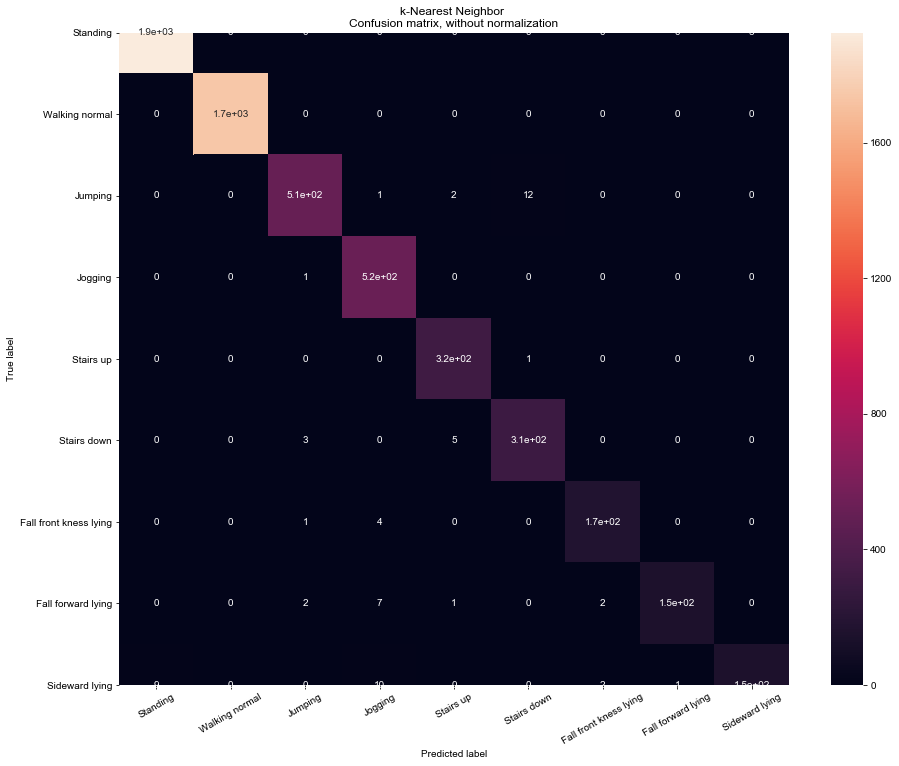

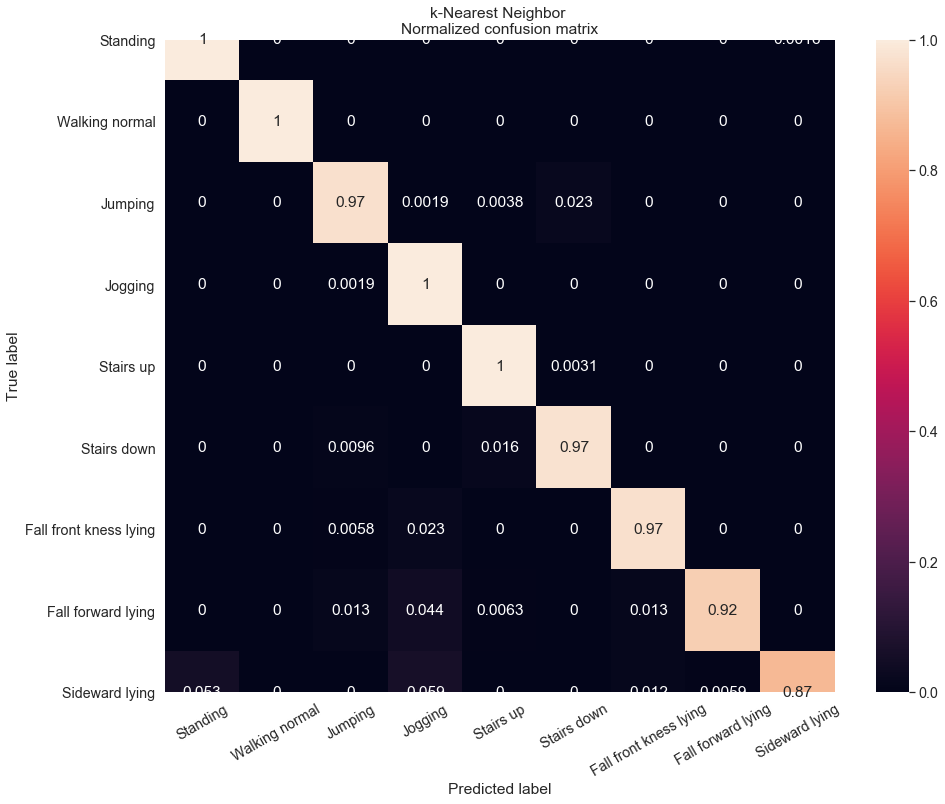


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1927
           1       1.00      1.00      1.00      1742
           2       0.99      0.97      0.98       525
           3       0.96      1.00      0.98       525
           4       0.98      1.00      0.99       321
           5       0.96      0.97      0.97       314
           6       0.98      0.97      0.97       171
           7       0.99      0.92      0.96       158
           8       0.98      0.87      0.92       170

    accuracy                           0.99      5853
   macro avg       0.98      0.97      0.97      5853
weighted avg       0.99      0.99      0.99      5853



In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sb
from sklearn.utils.multiclass import unique_labels

y_pred = knn.predict(test_features)
lables = np.concatenate([target_names, ])

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False, title=None):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize = (15,12))
    #Create a 2-dim array include: rows, columns, data
    dataFrame = pd.DataFrame(cm)
    #create a heatmap, annot = True: add text on each cell over heatmap
    sb.heatmap(dataFrame, annot = True)  
    ax.set(xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

    sb.set(font_scale = 1.3)

np.set_printoptions(precision=2) #lam tron

plot_confusion_matrix(test_label, y_pred, classes=lables,
        title='k-Nearest Neighbor \nConfusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(test_label, y_pred, classes=lables, normalize=True,
        title='k-Nearest Neighbor \nNormalized confusion matrix')

plt.show()
print ("\nClassification Report: ")
print (classification_report(test_label, y_pred))


9


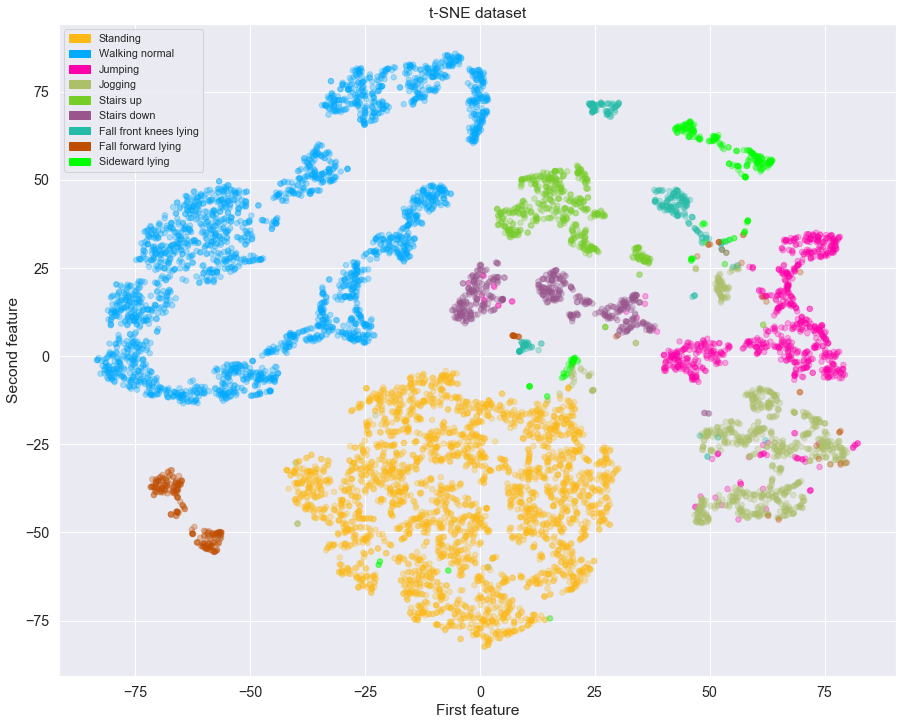

In [11]:
# t-SNE

import numpy
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn import neighbors
import graphviz 
from sklearn.tree import export_graphviz
import matplotlib.patches as mpatches


def plot_labelled_scatter(X, y, class_labels):
    num_labels = len(class_labels)
    print(num_labels)

    # create a mesh (lưới) to plot the boundaries (đường biên)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1   # min & max for feature 1 ((column 0)) 
                    # X[row, column]
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1   # min & max for feature 2 (column 1)
    

    # marker_shapes = ['v', 's', 'o', '^', '*']
    # Create array color of 7 behaviors
    colors = ['#fdb915', '#00AAFF', '#FF00AA', '#acbf69', 
              #'#ff0000'- red,  
              '#76cd26','#98568d',#'#b00149', 
              '#24bca8', '#c04e01','#00FF00']
    cmap = ListedColormap(colors) 
    
   # Generate a colormap index based on discrete intervals
    norm = BoundaryNorm(numpy.arange(0, num_labels+1, 1), ncolors=num_labels) 
    
    plt.figure(figsize=(15, 12))  # độ dài row & column của 
    
    plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=cmap, norm=norm, alpha=0.3, lw=1)
                #edgecolor='black'
    
    # Create array h[] chứa chú thích behaviors & colors tương ứng
    h = []
    for c in range(0, num_labels):
        # tạo chú thích = mpatches.Patch
        h.append(mpatches.Patch(color=colors[c], label=class_labels[c])) 
    plt.legend(handles=h, fontsize = 'x-small') # show ghi chu
    
    plt.xlabel('First feature')
    plt.ylabel('Second feature')
    plt.title('t-SNE dataset')

    plt.show()
    
X_visual = train_features
y_visual = np.array(train_label, dtype=np.uint8) # np.array: create array
                                                    # np.uint8: unsigned integer

n_samples = 300
n_components = 2  # dimension
perplexity = 30.0 # number of NEAREST NEIGHBORS that used in other MALIFOLD LEARNING algorithm (value: 5-50)
RS = 1000   

from sklearn.manifold import TSNE
# fit X_visual into embedding space in low-dimensional space and return  array (n_samples, n_components) 
X_tsne = TSNE(random_state=RS,).fit_transform(X_visual)
#type(X_tsne): numpy.ndarray
#  n_components=2, perplexity=30.0, learning_rate=300.0                   
plot_labelled_scatter(X_tsne, y_visual,['Standing','Walking normal','Jumping','Jogging',
                                        'Stairs up','Stairs down',
                                        'Fall front knees lying',
                                        'Fall forward lying','Sideward lying'])


<Figure size 800x320 with 0 Axes>

ValueError: shape mismatch: objects cannot be broadcast to a single shape

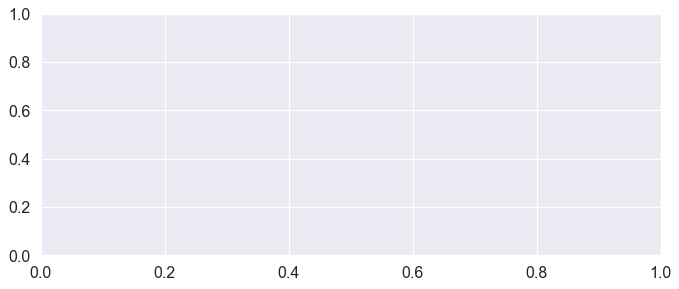

In [12]:
# adspy_shared_utilities import plot_feature_importances
# Atturibute Feature importances only use for classifiers contain trees

def plot_feature_importances(clf, feature_names):
    c_features = len(feature_names)
    plt.barh(range(c_features), clf.feature_importances_)
    plt.xlabel("Tầm quan trọng của đặc trưng")
    plt.ylabel("Tên đặc trưng")
    plt.yticks(numpy.arange(c_features), feature_names)
    
plt.figure(figsize=(10,4), dpi=80)
plot_feature_importances(clf1, feature_names)
plt.show()

print('Feature importances: {}'.format(clf1.feature_importances_))

In [ ]:
#Visualize A Decision Tree
#https://chrisalbon.com/machine_learning/trees_and_forests/visualize_a_decision_tree/
import graphviz
from sklearn.tree import DecisionTreeClassifier
from adspy_shared_utilities import plot_decision_tree
from IPython.display import Image
from sklearn import tree
import pydotplus

import os
os.environ["PATH"] += os.pathsep + r'F:\Python file\Graphviz\bin'
# Create DOT data
dot_data = tree.export_graphviz(clf2, out_file=None,
                               feature_names = feature_names,
                               class_names = target_names)
# Draw graph                               
graph = pydotplus.graph_from_dot_data(dot_data)
 
# Show graph                            
Image(graph.create_png()) 

#Create png
graph.write_pdf("tree.png")

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from adspy_shared_utilities import plot_decision_tree

plot_decision_tree(clf2, feature_names, target_names)
Image(graph.create_png()) 